In [ ]:
 !pip install torch torchvision matplotlib pandas --quiet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import torchsummary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


100%|██████████| 170M/170M [00:01<00:00, 103MB/s]


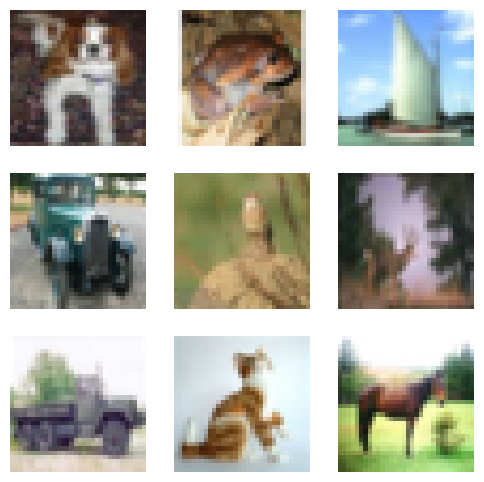

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Show some sample images
images, _ = next(iter(trainloader))
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.axis('off')
plt.show()

In [ ]:
 ##1. Vanilla Autoencoder (Fully Connected)
class VanillaAutoencoder(nn.Module):
    def __init__(self):
        super(VanillaAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32*32*3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# 2. Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # 16x16x16
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x8x8
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64x4x4
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1), # 32x8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), # 16x16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, output_padding=1, padding=1), # 3x32x32
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# 3. Variational Autoencoder
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32*32*3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [ ]:
# Step 3: Training Function
# ========================================

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + KLD) / x.size(0)

def train_model(model, epochs=5, lr=1e-3, is_vae=False):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0
        for imgs, _ in trainloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            if is_vae:
                recon, mu, logvar = model(imgs)
                loss = vae_loss(recon, imgs, mu, logvar)
            else:
                recon = model(imgs)
                loss = nn.functional.mse_loss(recon, imgs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss/len(trainloader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {losses[-1]:.4f}")

    training_time = time.time() - start_time
    return model, losses, training_time

In [ ]:
# Step 4: Train All Models
# ========================================
results = []

# Vanilla
vanilla = VanillaAutoencoder()
vanilla, v_loss, v_time = train_model(vanilla, epochs=5)
params_v = sum(p.numel() for p in vanilla.parameters())
results.append(["Vanilla AE", v_loss[-1], v_time, params_v])

# Conv
conv = ConvAutoencoder()
conv, c_loss, c_time = train_model(conv, epochs=5)
params_c = sum(p.numel() for p in conv.parameters())
results.append(["Conv AE", c_loss[-1], c_time, params_c])

# VAE
vae = VariationalAutoencoder()
vae, vae_loss_hist, vae_time = train_model(vae, epochs=5, is_vae=True)
params_vae = sum(p.numel() for p in vae.parameters())
results.append(["VAE", vae_loss_hist[-1], vae_time, params_vae])


Epoch 1/5, Loss: 0.0270
Epoch 2/5, Loss: 0.0158
Epoch 3/5, Loss: 0.0134
Epoch 4/5, Loss: 0.0122
Epoch 5/5, Loss: 0.0113
Epoch 1/5, Loss: 0.0208
Epoch 2/5, Loss: 0.0095
Epoch 3/5, Loss: 0.0074
Epoch 4/5, Loss: 0.0064
Epoch 5/5, Loss: 0.0058
Epoch 1/5, Loss: 140.6164
Epoch 2/5, Loss: 117.0466
Epoch 3/5, Loss: 108.0142
Epoch 4/5, Loss: 104.2784
Epoch 5/5, Loss: 96.3112


Vanilla AE Reconstructions


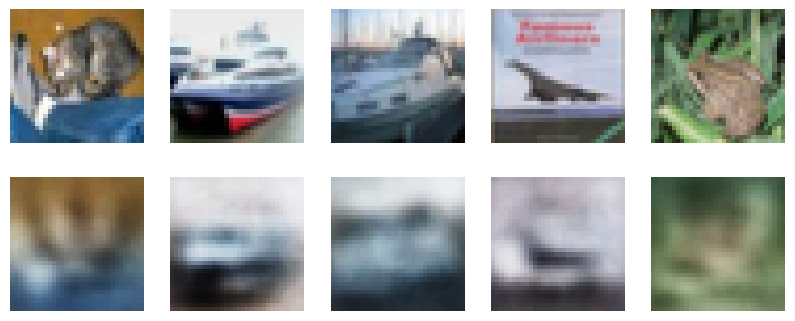

Conv AE Reconstructions


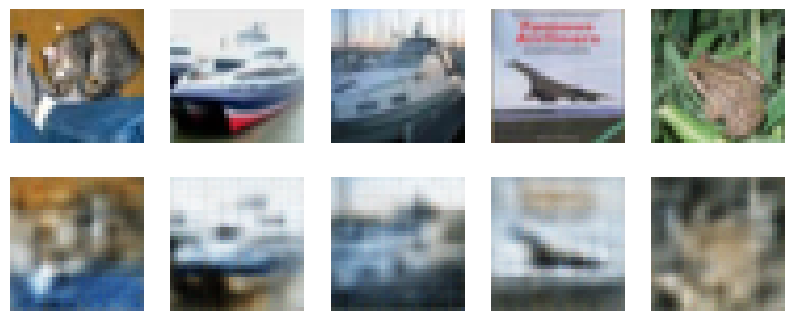

VAE Reconstructions


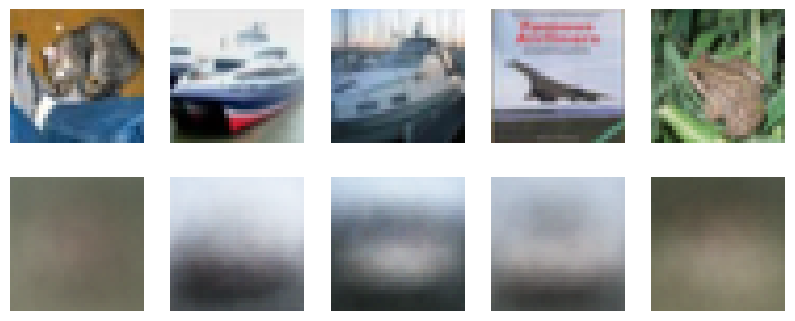

In [ ]:
 # ========================================
# Step 5: Evaluation - Reconstructed Images
# ========================================
def show_reconstructions(model, is_vae=False, n=5):
    model.eval()
    imgs, _ = next(iter(testloader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        if is_vae:
            recon, _, _ = model(imgs)
        else:
            recon = model(imgs)
    imgs = imgs.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(10,4))
    for i in range(n):
        # original
        plt.subplot(2,n,i+1)
        plt.imshow(np.transpose(imgs[i], (1,2,0)))
        plt.axis('off')
        # reconstructed
        plt.subplot(2,n,n+i+1)
        plt.imshow(np.transpose(recon[i], (1,2,0)))
        plt.axis('off')
    plt.show()

print("Vanilla AE Reconstructions")
show_reconstructions(vanilla)

print("Conv AE Reconstructions")
show_reconstructions(conv)

print("VAE Reconstructions")
show_reconstructions(vae, is_vae=True)


In [ ]:
# ========================================
# Step 6: Comparative Report
# ========================================
df = pd.DataFrame(results, columns=["Model", "Final Loss (MSE)", "Training Time (s)", "Parameters"])
print(df)


        Model  Final Loss (MSE)  Training Time (s)  Parameters
0  Vanilla AE          0.011279         391.581301     6821120
1     Conv AE          0.005753         165.541578       47107
2         VAE         96.311230         482.999244     7543040
